# Covid 19 Topic Analysis


*The follwing Analysis is broken into three parts:*



*   **Part One**: runs a paramter grid search using k, passes,interations and chunksize as varibles. The objective here was to understand how these vairbles interacted with coherence.
*   **Part Two**: using the information obtained in part two, and through trial and error the LDA model was trained.
*   **Part Three**: After obtaining an LDA model, this section will analyze the models topic assignment (still on going).





## **Part One**: Grid Search


In [1]:
#### cleaning up forieng articles
import pandas as pd 
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install pyLDAvis
master = pd.read_csv('/content/drive/My Drive/covid 19 exploration/df/master_text.csv')
master
print(f"total Foreign articles dropes : {sum(master.main_text.str.contains(r' de | une | di '))}")

new_master = master[~master.main_text.str.contains(r' de | une | di | de | del | con | von | der ')]  #### previous runs should that i need to drop foereign articles
new_master

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 19.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=d7594f93bdc1ec2b30acae0ce1d57bbfa9585401e64c5e37c1bd8dfba406b54e
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=6f834982cd8c2e35e016373ce33c1cad728bd56532da5f46fa7d7f671cba2742
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
total Fo

,Unnamed: 0,paper_id,papepr_title,abstract,main_text,file_path
1,1,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across Chin...,biorxiv_medrxi
2,2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant...,"Infectious bronchitis (IB), which is caused b...",biorxiv_medrxi
3,3,0139ea4ca580af99b602c6435368e7fdbefacb03,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recentl...,Nipah is an infectious negative-sense single-...,biorxiv_medrxi
4,4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Assessing spread risk of Wuhan novel coronavir...,Background: A novel coronavirus (2019-nCoV) e...,"In December 2019, a cluster of patients with ...",biorxiv_medrxi
5,5,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,"TWIRLS, an automated topic-wise inference meth...",Faced with the current large-scale public hea...,The sudden outbreak of the new coronavirus (S...,biorxiv_medrxi
...,...,...,...,...,...,...
29309,29309,ff3db609dbf2669d8d528279ef32280c2646ba85,More than efficacy revealed by single-cell ana...,Because many aspects of viral infection dynam...,"Over the past few decades, the world has witn...",noncomm_use_subse
29311,29311,ff6d57f2aad99be129432058665b361dc18747e8,Brief Definitive Report MACROPHAGES GENETICALL...,There is extensive evidence that cultured mac...,Experiments were designed to test whether sub...,noncomm_use_subse
29312,29312,ff83907653a4c4500e8c509ca28169e924742b40,Identification of a Subdomain of CENPB That Is...,We have combined in vivo and in vitro approac...,"can function in an autonomous fashion, reloca...",noncomm_use_subse
29313,29313,ffe718db1820f27bf274e3fc519ab78e450de288,Replication enhancer elements within the open ...,We provide experimental evidence of a replica...,Tick-borne encephalitis virus (TBEV) is a hum...,noncomm_use_subse


In [3]:
from nltk import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sys
word_list = new_master.sample(n=10000).main_text.to_list()
stop_words=set(stopwords.words('english'))

counter=0
nreviews_list = []
for i,review in enumerate(word_list):
    # split into tokens by white space
    tokens = review.split()

    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words]

    ntokens = ' '.join(tokens)
    nreviews_list.append(ntokens)
    
    counter+=1
    if counter%1000 == 0: 
      print(f"interation {i+1} of {new_master.shape[0]}")


docs = [word_tokenize(doc) for doc in nreviews_list]
lam=WordNetLemmatizer()
 
tokens =[[lam.lemmatize(token) for token in doc]for doc in docs]

#### bag of word freq
from gensim.corpora import Dictionary
dictionary = Dictionary(tokens)
dictionary.filter_extremes(no_below=10, no_above = .50, keep_n=100000 )
corpus = [dictionary.doc2bow(doc) for doc in docs]

# ##### bag of wrod TFIDF
# from gensim import corpora, models
# tfidf = models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]

interation 1000 of 23903
interation 2000 of 23903
interation 3000 of 23903
interation 4000 of 23903
interation 5000 of 23903
interation 6000 of 23903
interation 7000 of 23903
interation 8000 of 23903
interation 9000 of 23903
interation 10000 of 23903


In [0]:
# Compute Coherence Score using c_v
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from sklearn.model_selection import ParameterGrid
import pickle as pkl

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

grid = {
    'chunksize' :[10, 100, 1000, 5000],
    'k': [10,30,60,100],
    'iterations': [2,5,10],
    'passes': [2,4,10]
}

grid = ParameterGrid(grid)
coherence =[]
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

for i, param in enumerate(grid):
  model = LdaMulticore(
      corpus=corpus,
      id2word=id2word,
      chunksize=param['chunksize'],
      iterations=param['iterations'],
      num_topics=param['k'],
      passes=param['passes'],
      eval_every=None, workers=3
  )
  
  coherence_model_lda = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence.append(coherence_lda)
  print(f"coherence is {coherence_lda}, with parameters: {param}")



pickle.dump( coherence, open( "coherence.pkl", "wb" ) )
pickle.dump( grid, open( "coherence_grid.pkl", "wb" ) )

coherence is 0.5631053678459261, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 10, 'passes': 2}
coherence is 0.5739329175391215, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 10, 'passes': 4}
coherence is 0.5837417472701244, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 10, 'passes': 10}
coherence is 0.599637240461591, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 30, 'passes': 2}
coherence is 0.604661991970694, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 30, 'passes': 4}
coherence is 0.6175600942901699, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 30, 'passes': 10}
coherence is 0.5993064115418556, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 60, 'passes': 2}
coherence is 0.62182583480824, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 60, 'passes': 4}
coherence is 0.6267448682358495, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 60, 'passes': 10}


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


coherence is 0.5806760371840709, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 100, 'passes': 2}
coherence is 0.6066451452817598, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 100, 'passes': 4}
coherence is 0.6197928477537293, with parameters: {'chunksize': 10, 'iterations': 2, 'k': 100, 'passes': 10}
coherence is 0.5909063468950102, with parameters: {'chunksize': 10, 'iterations': 5, 'k': 10, 'passes': 2}
coherence is 0.6134675626569294, with parameters: {'chunksize': 10, 'iterations': 5, 'k': 10, 'passes': 4}
coherence is 0.5950400794344761, with parameters: {'chunksize': 10, 'iterations': 5, 'k': 10, 'passes': 10}
coherence is 0.6184845555204441, with parameters: {'chunksize': 10, 'iterations': 5, 'k': 30, 'passes': 2}
coherence is 0.6371783161338377, with parameters: {'chunksize': 10, 'iterations': 5, 'k': 30, 'passes': 4}
coherence is 0.6429992204760216, with parameters: {'chunksize': 10, 'iterations': 5, 'k': 30, 'passes': 10}
coherence is 0.6255737178755214

Text(0.5, 0.98, 'Parameters for LDA')

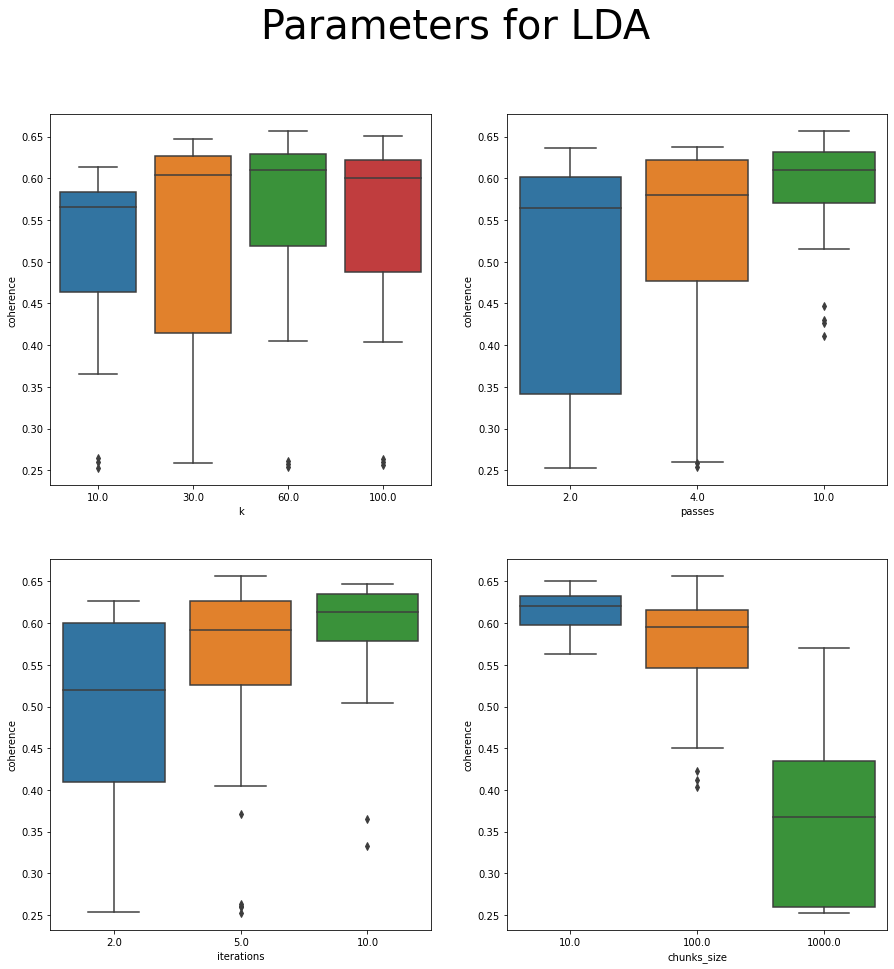

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
params=pd.read_csv('/content/drive/My Drive/covid 19 exploration/df/coherence_params.csv')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,  figsize=(15,15))
sns.boxplot(y=params.coherence, x=params.k, ax=ax1)
sns.boxplot(y=params.coherence, x=params.passes, ax=ax2)
sns.boxplot(y=params.coherence, x=params.iterations, ax=ax3)
sns.boxplot(y=params.coherence, x=params.chunks_size, ax=ax4)
fig.suptitle('Parameters for LDA', size=40)

## **Part Two**: Training LDA


### Creating Bag of Words


In [4]:


from nltk import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sys
word_list = new_master.main_text.to_list()#[1:5]
stop_words=set(stopwords.words('english'))

counter=0
nreviews_list = []
for i,review in enumerate(word_list):
    # split into tokens by white space
    tokens = review.split()

    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words]

    ntokens = ' '.join(tokens)
    nreviews_list.append(ntokens)
    
    counter+=1
    if counter%1000 == 0: 
      print(f"interation {i+1} of {new_master.shape[0]}")


docs = [word_tokenize(doc) for doc in nreviews_list]
lam=WordNetLemmatizer()
 
tokens =[[lam.lemmatize(token) for token in doc]for doc in docs]

#### bag of word freq
from gensim.corpora import Dictionary
dictionary = Dictionary(tokens)
dictionary.filter_extremes(no_below=15, no_above = .40, keep_n=100000 )
corpus = [dictionary.doc2bow(doc) for doc in docs]

##### bag of wrod TFIDF
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

interation 1000 of 23903
interation 2000 of 23903
interation 3000 of 23903
interation 4000 of 23903
interation 5000 of 23903
interation 6000 of 23903
interation 7000 of 23903
interation 8000 of 23903
interation 9000 of 23903
interation 10000 of 23903
interation 11000 of 23903
interation 12000 of 23903
interation 13000 of 23903
interation 14000 of 23903
interation 15000 of 23903
interation 16000 of 23903
interation 17000 of 23903
interation 18000 of 23903
interation 19000 of 23903
interation 20000 of 23903
interation 21000 of 23903
interation 22000 of 23903
interation 23000 of 23903


### Training LDA Model

In [12]:
# Train LDA model.
from gensim.models import LdaMulticore
import multiprocessing
from gensim.models import CoherenceModel
pool = multiprocessing.Pool()
pool._processes
# Set training parameters.
wrokers= pool._processes - 1   ### for setting the number of workers
num_topics = 12 ### should be between 5 to 20 hueristic
chunksize = 10
passes = 10  
iterations = 10 
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every, workers=wrokers
)

print("model fit")
coherence_model_lda = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"coherence is {coherence_lda}")

model fit
coherence is 0.615440432431745


In [13]:
coherence_lda

0.615440432431745

## **Part Three**: Analyzing the Results

### Vizsualizing the Results

In [14]:
# Visualize the topics
import pyLDAvis

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.171594  0.134549       1        1  13.901395
3     -0.036767  0.004549       2        1  10.500077
11    -0.224486 -0.073213       3        1  10.381227
1     -0.221985 -0.014955       4        1   9.837029
5      0.206830 -0.047182       5        1   9.824828
6     -0.000100  0.181185       6        1   8.976370
4      0.007933 -0.192702       7        1   8.888352
10    -0.054604  0.078203       8        1   7.707328
7      0.227267  0.089374       9        1   6.870217
8      0.067502 -0.175367      10        1   5.668452
2      0.030996 -0.160174      11        1   3.756365
0     -0.174180  0.175732      12        1   3.688365, topic_info=              Term          Freq         Total Category  logprob  loglift
1358    expression  78875.000000  78875.000000  Default  30.0000  30.0000
514        vaccine  63580.000000  63580.000000  Default  29.0000  29.0000
344      influenza  79271.000000  79271.000000  Default  28.0000  28.0000
408            pcr  47397.000000  47397.000000  Default  27.0000  27.0000
869   transmission  41327.000000  41327.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1671          mrna   6401.641113  20665.998047  Topic12  -5.0356   2.1281
958    coronavirus   6755.241211  25003.414062  Topic12  -4.9819   1.9913
2181      cleavage   5220.927734  12110.798828  Topic12  -5.2395   2.4586
6313         yeast   4769.041504   9460.074219  Topic12  -5.3300   2.6151
986            end   4587.602051  14692.802734  Topic12  -5.3688   2.1360

[893 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1742       4  0.024322        aa
1742      12  0.974910        aa
1746       1  0.999519  academic
535        1  0.782649    access
535        2  0.059609    access
...      ...       ...       ...
23483      6  0.998386        ðt
23484      9  0.997886       ðtþ
18983      6  0.999864         þ
4262       6  0.999495         γ
3975       6  0.999508         λ

[2488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 12, 2, 6, 7, 5, 11, 8, 9, 3, 1])

In [17]:
%cd "/content/drive/My Drive/covid 19 exploration/LDA"
import pickle as pkl
model.save('lda.model')
pkl.dump(dictionary, open('lda_dict.pkl', 'wb'))
pkl.dump(corpus, open('corpus.pkl', 'wb'))

/content/drive/My Drive/covid 19 exploration/LDA


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
